# **Preprocessing**

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Connect google drive to colab
from google.colab import drive

drive.mount('/content/gdrive')
root_path = '/content/gdrive/MyDrive/EfficientNet_Model_Dataset' #This path for test data, it's just for to show confusion matrix and in this repository we didn't give you dataset for test. We suggest to comment this line.
root_path2 = '/content/gdrive/MyDrive/eks4'

Mounted at /content/gdrive


In [3]:
# Declare path each data
train_dir = root_path2 + '/train'
validation_dir = root_path2 + '/val'
testing_dir = root_path + '/test'

In [4]:
# Data Augmentation
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip = True,
    rotation_range = 0.2 ,
    zoom_range = 0.2,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip = True,
    rotation_range = 0.2 ,
    zoom_range = 0.2,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
)

In [5]:
train_batch_size = 20
val_batch_size = 10

train_images = train_generator.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=train_batch_size,
    shuffle=True,
    seed=42,
)

val_images = train_generator.flow_from_directory(
    directory=validation_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=val_batch_size,
    shuffle=True,
    seed=42,
)

test_images = test_generator.flow_from_directory(
    directory=testing_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=20,
    shuffle=False
)

Found 3554 images belonging to 10 classes.
Found 391 images belonging to 10 classes.
Found 200 images belonging to 10 classes.


# **Training Process**

In [6]:
# Input transfer learning model using Efficient Net B0
pretrained_model = tf.keras.applications.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

16719872/16705208 [==============================] - 0s 0us/step


In [7]:
# Adding more layer in top of based model for fine tuning
inputs = pretrained_model.input

x = tf.keras.layers.Flatten()(pretrained_model.output)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0]']      

In [8]:
# Training process

model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/20
178/178 [==============================] - 2058s 12s/step - loss: 2.0828 - accuracy: 0.3340 - val_loss: 1.6056 - val_accuracy: 0.6087
Epoch 2/20
178/178 [==============================] - 224s 1s/step - loss: 1.2369 - accuracy: 0.6427 - val_loss: 0.8202 - val_accuracy: 0.7724
Epoch 3/20
178/178 [==============================] - 224s 1s/step - loss: 0.8168 - accuracy: 0.7535 - val_loss: 0.6175 - val_accuracy: 0.8338
Epoch 4/20
178/178 [==============================] - 226s 1s/step - loss: 0.6635 - accuracy: 0.7904 - val_loss: 0.4877 - val_accuracy: 0.8568
Epoch 5/20
178/178 [==============================] - 225s 1s/step - loss: 0.5739 - accuracy: 0.8216 - val_loss: 0.4432 - val_accuracy: 0.8619
Epoch 6/20
178/178 [==============================] - 225s 1s/step - loss: 0.5142 - accuracy: 0.8391 - val_loss: 0.4105 - val_accuracy: 0.8568
Epoch 7/20
178/178 [==============================] - 226s 1s/step - loss: 0.4712 - accuracy: 0.8528 - val_loss: 0.3667 - val_accuracy: 0.88

# **Training Results**

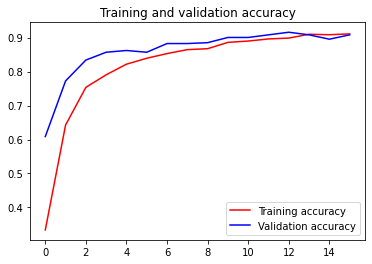

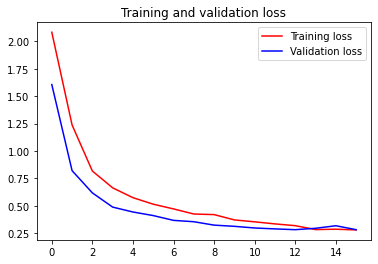

<Figure size 432x288 with 0 Axes>

In [9]:
# Plotting learning curve
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

In [10]:
# Evaluate model to test image
batch_size =20
test_score = model.evaluate_generator(test_images, batch_size)
print("[INFO] accuracy: {:.2f}%".format(test_score[1] * 100))
print("[INFO] Loss: ",test_score[0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


[INFO] accuracy: 91.50%
[INFO] Loss:  0.2196951061487198


# **Model Evaluation**

In [11]:
# Plot to make confusion matrix
import numpy as np
import itertools
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm = np.around(cm, decimals=2)
    cm[np.isnan(cm)] = 0.0
    print("Normalized confusion matrix")
  else:
    print("Confusion matrix, without normalization")

  print(cm)

  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

In [12]:
y = np.concatenate([test_images.next()[1] for i in range (test_images.__len__())])
true_labels=np.argmax(y, axis=-1)
prediction = model.predict(test_images, verbose=2)
prediction = np.argmax(prediction, axis=-1)

10/10 - 12s - 12s/epoch - 1s/step


Confusion matrix, without normalization
[[18  0  0  0  0  0  0  2  0  0]
 [ 0 20  0  0  0  0  0  0  0  0]
 [ 0  0 20  0  0  0  0  0  0  0]
 [ 0  1  0 18  0  0  1  0  0  0]
 [ 0  0  0  0 17  0  3  0  0  0]
 [ 0  0  1  0  0 19  0  0  0  0]
 [ 0  0  0  0  0  0 19  1  0  0]
 [ 0  1  0  0  0  0  1 16  2  0]
 [ 0  0  0  0  0  0  0  0 20  0]
 [ 0  0  0  0  0  0  0  0  0 20]]
Accuracy: 0.935
Precision: 0.930
Recall: 0.935
F-Measure: 0.935


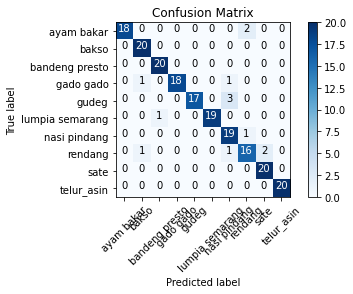

In [13]:
# Confusion matrix
target_names = []
for key in train_images.class_indices:
    target_names.append(key)

cm = confusion_matrix(true_labels, prediction)
plot_confusion_matrix(cm=cm,classes=target_names, title="Confusion Matrix")

# Accuracy
from sklearn.metrics import accuracy_score
acc = accuracy_score(true_labels,prediction)
print("Accuracy: %.3f" % acc)

# Precision
from sklearn.metrics import precision_score
precision = precision_score(true_labels,prediction, labels=[1,2], average='micro')
print("Precision: %.3f" % precision)

# Recall
from sklearn.metrics import recall_score
recall = recall_score(true_labels,prediction, average='micro')
print("Recall: %.3f" % recall)

# F1 score
from sklearn.metrics import f1_score
score = f1_score(true_labels,prediction, average='micro')
print("F-Measure: %.3f" % score)

In [14]:
#Predict using own image
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for image_test in uploaded.keys():
  # predicting images
  path = image_test
  img = image.load_img(path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  
  classes = model.predict(x, batch_size=20)
  predicted_ids = np.argmax(classes, axis=-1)

  category = ['ayam bakar', 'bakso', 'bandeng presto', 'gado gado', 'gudeg', 'lumpia semarang', 'nasi pindang', 'rendang', 'sate', 'telur asin']
  result = "{} is {}".format(image_test, category[int(predicted_ids)])
  print(image_test)
  print(int(predicted_ids))
  print(result)

Saving ayam bakar (6).jpg to ayam bakar (6).jpg
ayam bakar (6).jpg
0
ayam bakar (6).jpg is ayam bakar


# **Export Model**

In [15]:
#Export model to .tflite without quantization

import pathlib

tflite_models_dir = pathlib.Path("/content/gdrive/MyDrive/Model")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

tflite_model_file = tflite_models_dir/"food_model.tflite"
tflite_model_file.write_bytes(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp5q1qeyxe/assets


16530604

In [16]:
# Uncomment code until 'save the model' to try Other way to export model to .tflite without quantization 
#model.save('/content/gdrive/My Drive/Colab Notebooks/food_model.h5')

In [17]:
'''food_model = tf.keras.models.load_model('/content/gdrive/My Drive/Colab Notebooks/food_model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(food_model)
# Convert the model
tflite_model = converter.convert()
 
# Save the model.
with open('food_model.tflite', 'wb') as f:
  f.write(tflite_model)'''

"food_model = tf.keras.models.load_model('/content/gdrive/My Drive/Colab Notebooks/food_model.h5')\nconverter = tf.lite.TFLiteConverter.from_keras_model(food_model)\n# Convert the model\ntflite_model = converter.convert()\n \n# Save the model.\nwith open('food_model.tflite', 'wb') as f:\n  f.write(tflite_model)"

In [18]:
#Export model to .tflite with quantization

converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_quant_model = converter.convert()
tflite_model_quant_file = tflite_models_dir/"food_model_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_quant_model)

INFO:tensorflow:Assets written to: /tmp/tmpkug29is2/assets


INFO:tensorflow:Assets written to: /tmp/tmpkug29is2/assets


4910640